In [2]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
from utils import ECDF
from data import load_decay
import pandas as pd
import theano.tensor as tt
import arviz as az

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Arbitrary Curve Regression

Now that you've learned about Bayesian estimation, we're going to explore one more topic: Bayesian curve fitting.

By "curve fitting", we're really talking about any curve: those that are bendy, those that are straight, and those that are in between. 

In order to reinforce this point, rather than show you plain vanilla linear regression, we will work through an exponential decay curve example.

## Problem Setup

You've taken radioactive decay measurements of an unknown element in a secure facility. The measurements are noisy, though, and potentially have some bias. In the face of this, we would like to be able to characterize the decay constant of this unknown material, potentially leading to an identification of the material.

### Load Data

Let's load in the data.

In [3]:
np.random.seed(42)

df = load_decay()
df.head(5)

,t,activity
0,0,63.496714
1,1,62.281634
2,2,62.495498
3,3,62.806653
4,4,60.493075


Plot `activity` vs. `time`.

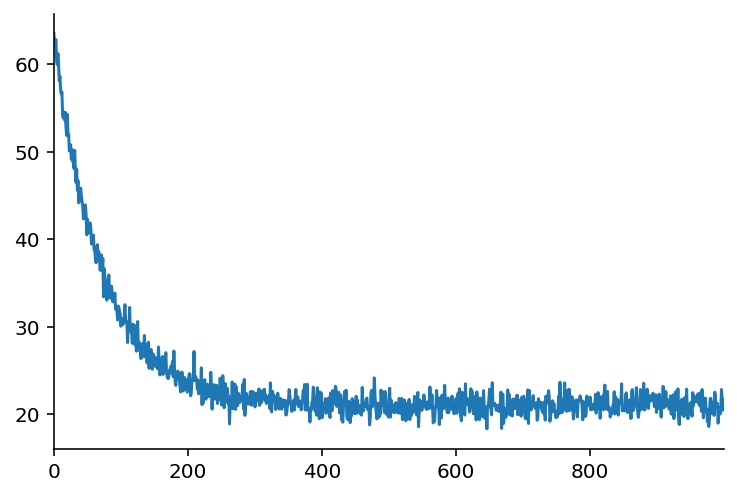

In [4]:
ax = df['activity'].plot()

### Discussion

- For the scenario that we're in, what is a plausible equation that links time to activity?
- What are the key parameters that we need to worry about?
- What might be justifiable priors for them?

Answers:
* [exponential decay equation](https://en.wikipedia.org/wiki/Exponential_decay)
* A, c, and Tau
* measurement are noisy (epsilon)

![exponential_decay](../images/exponential_decay.png)

* A <- something positive, A ~ Exp(lambda)
* Tau <- something positive, Tau ~ Exp(lambda)
* c <- systematic bias, instead of c ~ N(mu, sigma), we could do c ~ Exp(lambda)
** if machine goes crazy and give you the negative values, normal can be ok
* y ~ N(mu=A*exp(-t/tau)+c, sigma=epsilon)
* epsilon ~ half-cauchy

![parameter_distribution.png](../images/parameter_distribution.png)

### Link Functions

If we were to draw out a model for the curve above, how might it look like?

(To reveal one possible model, double-click on this Markdown cell and remove the `z` from the end of the filename.)

![](../images/radioactive-decay-model.jpg)

The most important part of this diagram is the "link function" - this is what "links" the data to the output. In this case, we've used the exponential decay curve as the link function, but if you were doing a linear regression model, all you would have to do is to change the link function for the $y=mx+c$ "straight curve", and do another curve fit with the appropriate priors for $m$ and $c$.

If you're familiar with the mathematical groundings of deep learning, you'll immediately recognize that a deep neural network model is merely another instance of a really complicated link function that links the input data $x$ to the observed data $y$, with the model weights and biases corresponding to the parameters (let's collectively call this set of parameters $\theta$).

### Hands-on: Model Implementation

Now that you've seen a pictorial description of the model, implement it below in PyMC3.

In [5]:
with pm.Model() as model:
    A = pm.HalfNormal('A', sd=100)
    tau = pm.Exponential('tau', lam=1)
    C = pm.Normal('C', sd=100)
    
    sd = pm.HalfCauchy('sd', beta=1)
    
    link = A * np.exp(-df['t'].values / tau) + C
    
    like = pm.Normal('activity', mu=link, sd=sd, observed=df['activity'].values)
    

### Sample from the Posterior

In [6]:
# Put your code here
with model:
    trace = pm.sample(2000, tune=2000)
    # Note: Sampler may pause for a while after finishing

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, C, tau, A]
100%|██████████| 4000/4000 [00:26<00:00, 148.70it/s]


### Visual Diagnostics

Check that sampling has converged.

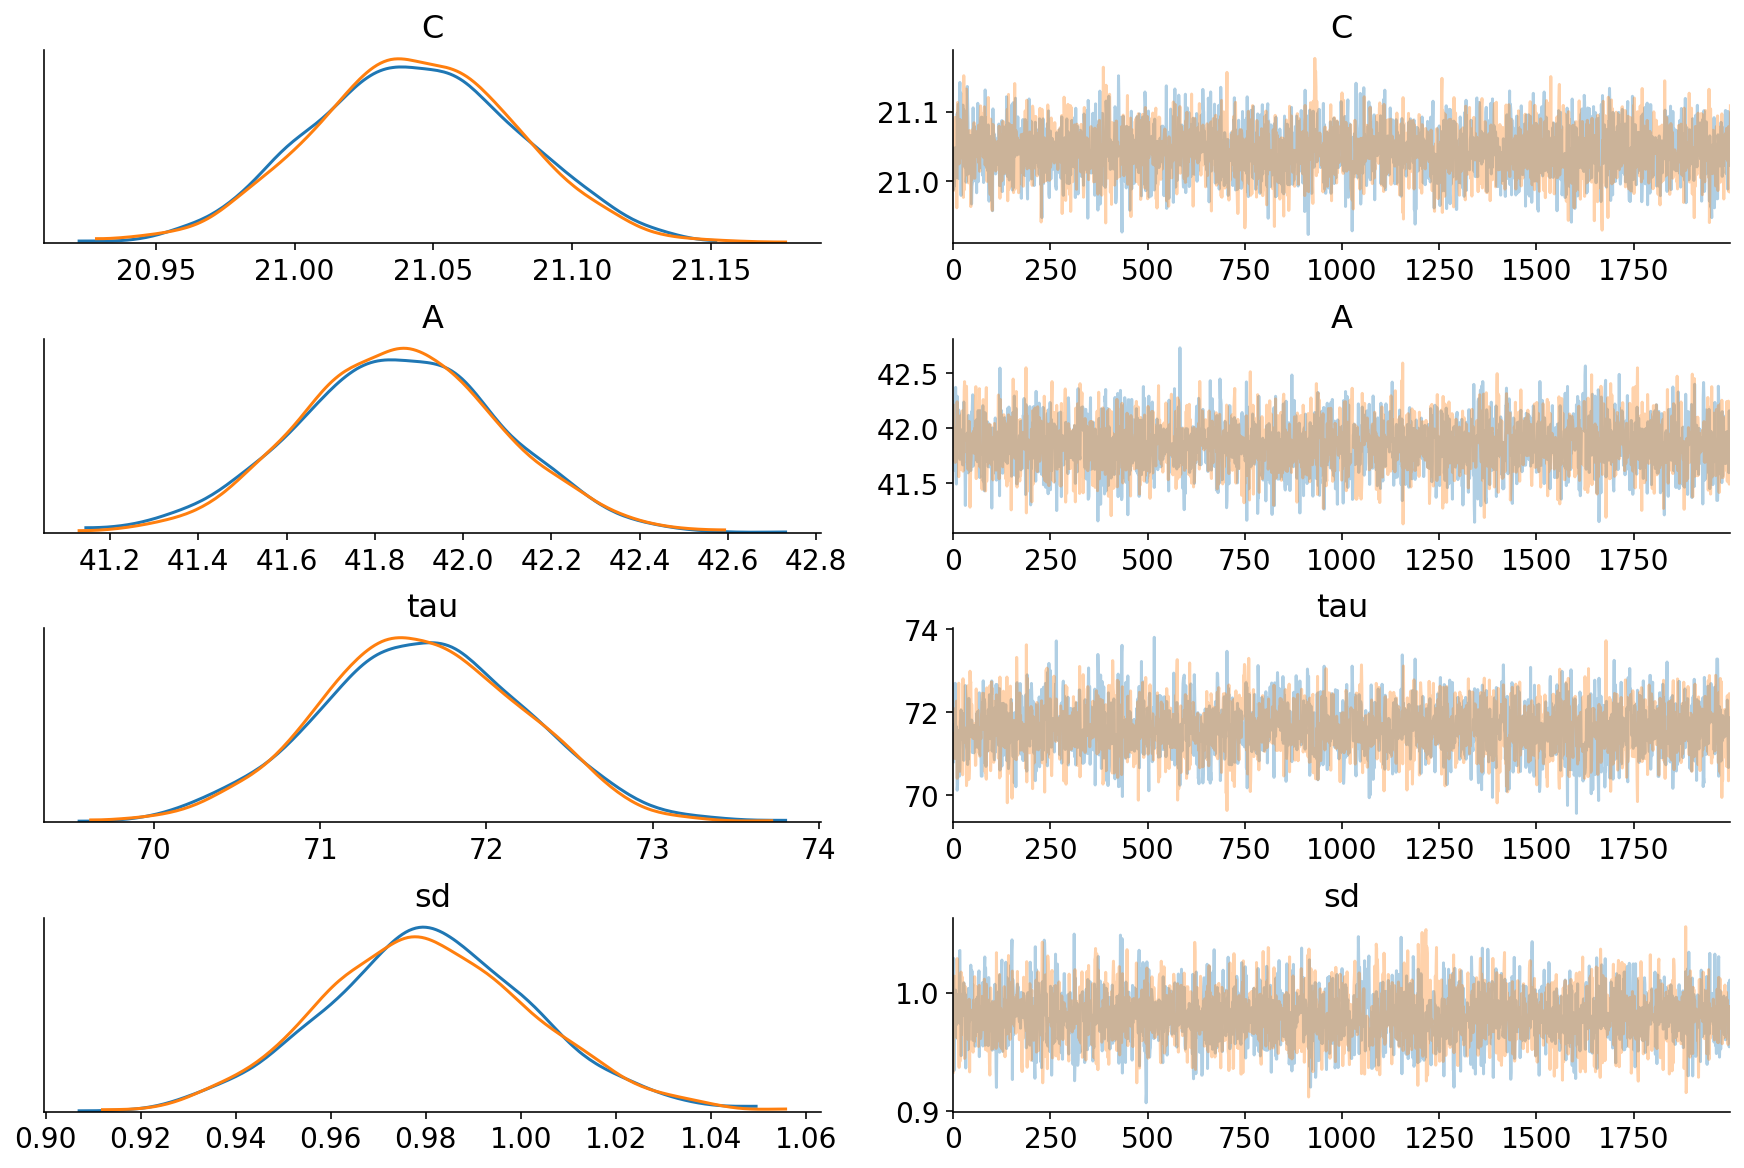

In [7]:
az.plot_trace(trace);

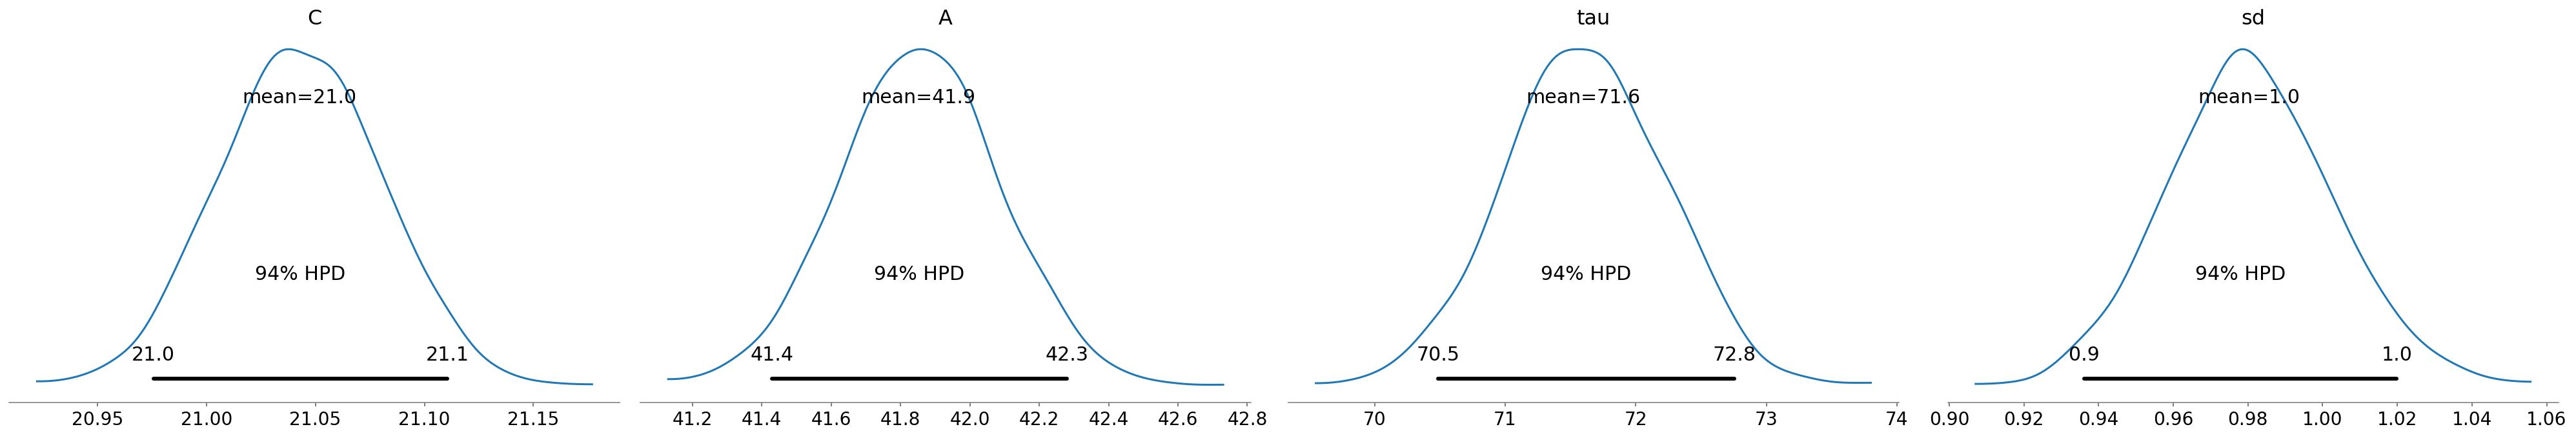

In [8]:
az.plot_posterior(trace);

# Summary

- In lieu of showing you a "straight curve" (line) fit, you've now seen an arbitrary curve fit.
- As long as you can find a way to parameterize the curve with a function, you can perform inference on the curve's parameters.
- That function is called the "link function", which provides the link between the parameters, data and the output.

More generally, if

$$y = f(x, \theta)$$

where $\theta$ are merely a set of parameters, then you can perform inference on the curve's parameters $\theta$. To make this clear:

| curve name | functional form | parameters |
|------------|-----------------|---------------------|
| exponential decay | $y = Ae^{-t/\tau} + C$ | $A$, $\tau$, $C$|
| sine curves | $y = A\sin(\omega  x + \phi)$ | $A$, $\omega$, $\phi$ |
| linear regression | $y = mx + c$ | $m$, $c$ |
| logistic regression | $y = L(mx + c)$ | $m$, $c$ |
| 4-parameter IC50 | $y = \frac{a - i}{1 + 10^{\beta(log(\tau) - x)}} + i$ | $a$, $i$, $\tau$, $\beta$ |
| deep learning | $y = f(x, \theta)$ | $\theta$ |

In [9]:
trace.varnames

['A_log__', 'tau_log__', 'C', 'sd_log__', 'A', 'tau', 'sd']

In [16]:
ts = np.linspace(0, 800, 4000)  # x-axis values

def exponential_decay(A, tau, C, x):
    return A * np.exp(-x / tau) + C

y_hat = exponential_decay(trace['A'], trace['tau'], trace['C'], ts)

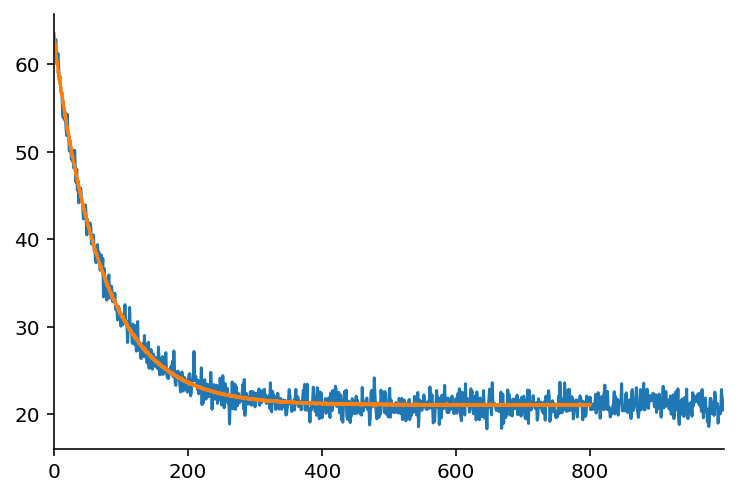

In [23]:
ax = df['activity'].plot()
plt.plot(ts, y_hat)
plt.show()

##### Bayes regression
![bayesian_regression](../images/bayesian_regression.jpg)

Reference: [bayes-regression-how-is-it-done-in-comparison-to-standard-regression](https://stats.stackexchange.com/questions/252577/bayes-regression-how-is-it-done-in-comparison-to-standard-regression)

[Bayesian_linear_regression Wiki](https://en.wikipedia.org/wiki/Bayesian_linear_regression)